#### Version 5: Outputs values in mm^2 using pixels_to_mm.py

In [87]:
# only needed in Jupyter Lab to see the images inline
%matplotlib widget

from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import shutil

In [92]:
# Central Path Locations

# Makes Base Directory where this script is running from:
BASE_DIR = os.getcwd()
# To access more than just what's in your Base Directory, use the following:
# BASE_DIR os.chdir("/path/to/your/folder")

# Uncomment to see what the Base Directory is, so you know the levels to add for the following paths
print(BASE_DIR)

# Change to where the image grabbed's dierctory (Temp_Staging_Area)
image_dir = os.path.join(BASE_DIR, "Image_Holder", "Temp_Staging_Area")
# For grabbing the image: Finds the only file in the folder
files = [f for f in os.listdir(image_dir) if not f.startswith(".")]
if len(files) == 0:
    raise FileNotFoundError(f"No files found in {image_dir}.")
elif len(files) > 1:
    print(f"Warning: More than one image in {image_dir}, using the first one.")
filename = files[0]
image_name = filename
image_path = os.path.join(image_dir, image_name)

# Change to Chamber folder: this is where the temporary data on pixel number in plants is saved
temp_desktop_image_results = os.path.join(BASE_DIR, "Temp_Results", "temp_desktop_image_results.json")
# Change to location where data from this run is saved
analysis_results_csv_path = os.path.join(BASE_DIR, "Final_Data", "desktop_analysis_log.csv")
# Change to location where scale_values is saved
scale_values_path = os.path.join(BASE_DIR, "Pixels_to_mm", "scale_values.json")
# Change to location where plant_names.csv is saved
plant_names_path = os.path.join(BASE_DIR, "desktop_plant_names.csv")

/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/Jupyter_Lab/WorkingVersion/Desktop_Version


In [ ]:
# Splits up plant name
name_without_ext, _ = os.path.splitext(filename)
parts = name_without

In [74]:
# Input/output options
args = WorkflowInputs(
    images=[image_path], # change to where the image will be
    names="image1",
    result=temp_desktop_image_results,
    outdir=".",
    writeimg=False,
    debug="plot"
    )

In [40]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

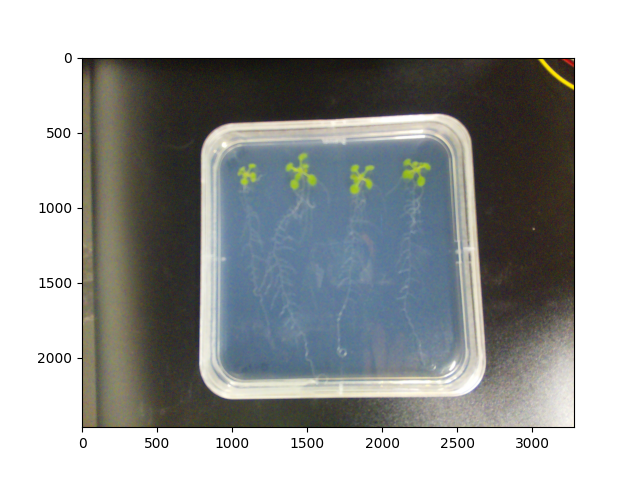

In [65]:
# Shows your image, defines it as "img"
img, path, filename = pcv.readimage(filename=args.image1)

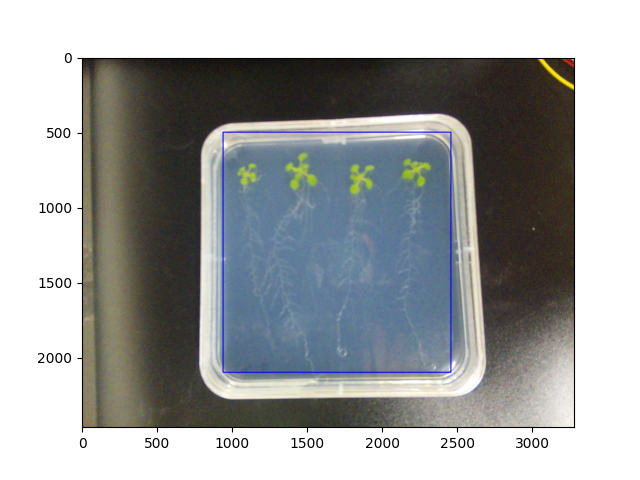

In [66]:
# Crops your image
crop_img = pcv.crop(img=img, x=940, y=500, h=1600, w=1520)

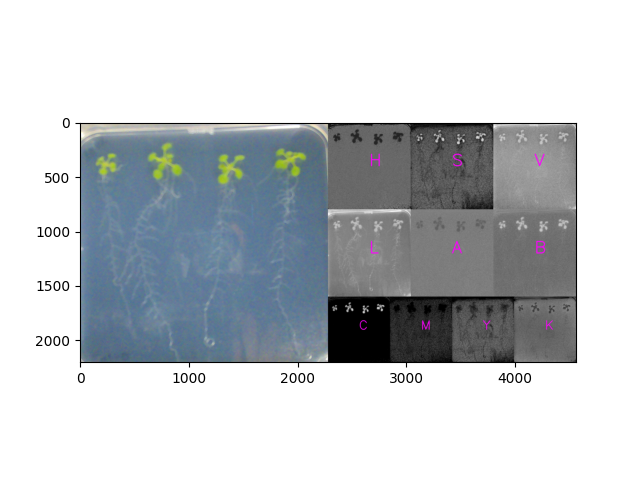

In [44]:
# Shows options for which channel to view the image through (ideally want the most contrast)
colorspace_img = pcv.visualize.colorspaces(rgb_img=crop_img)

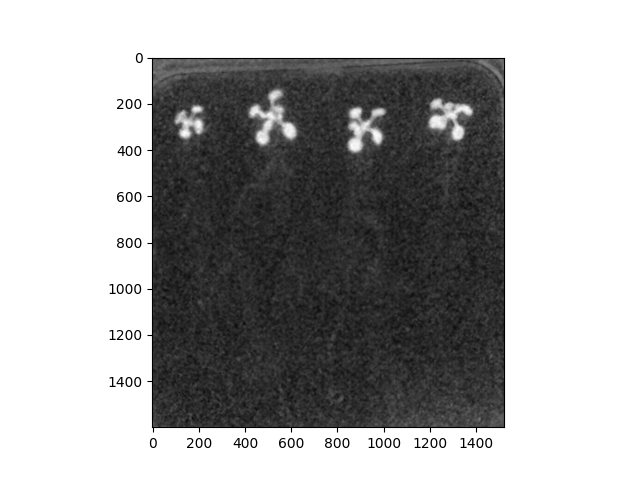

In [67]:
# Actually picks a channel with rgb2gray_"lab" and then the channel is the letter from "lab" that you look through
channeled_img = pcv.rgb2gray_lab(rgb_img=crop_img, channel='b')

In [46]:
# Visualization only, not needed for analysis
hist_figure1, hist_data1 = pcv.visualize.histogram(img = channeled_img, hist_data=True)

alt.Chart(...)

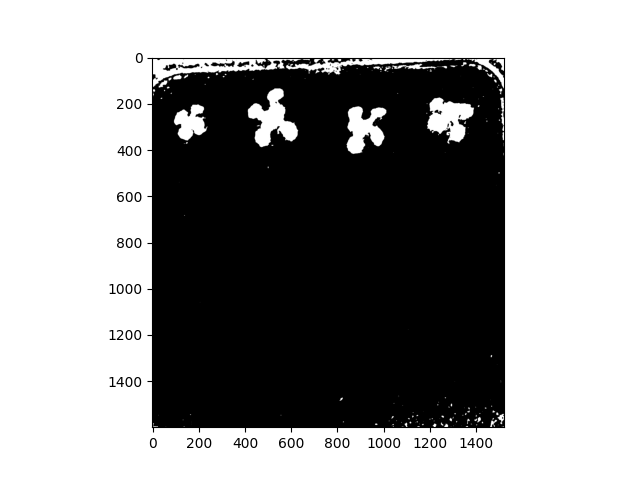

In [68]:
# Masks the image
thresh_mask = pcv.threshold.binary(gray_img=channeled_img, threshold=130, object_type='light')

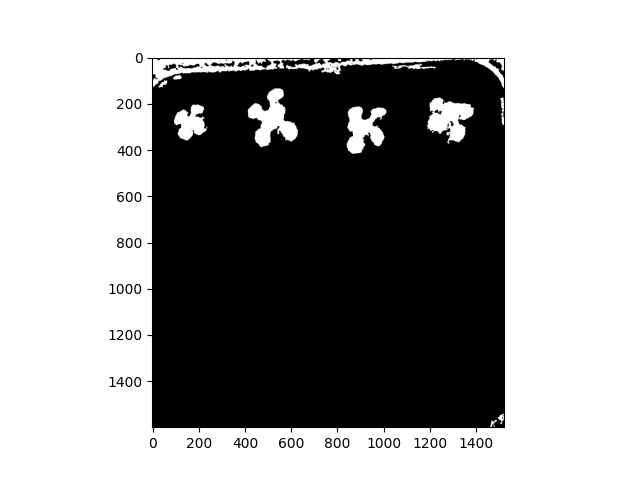

In [58]:
# Deletes groups of pixels less than the pixel size (weird dots around edges not plant is unmasked)
cleaned_mask = pcv.fill(bin_img=thresh_mask, size=300)

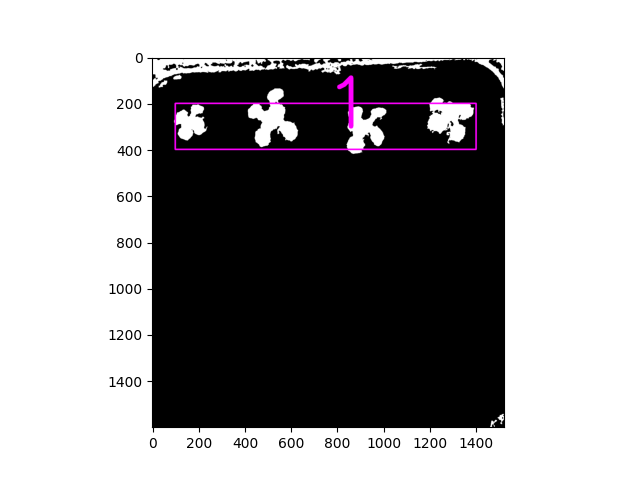

In [69]:
# Defines Region of Interest (ROI) which selects white pixels and deselects black pixels from a masked image
roi = pcv.roi.rectangle(img=cleaned_mask, x=100, y=200, h=200, w=1300)

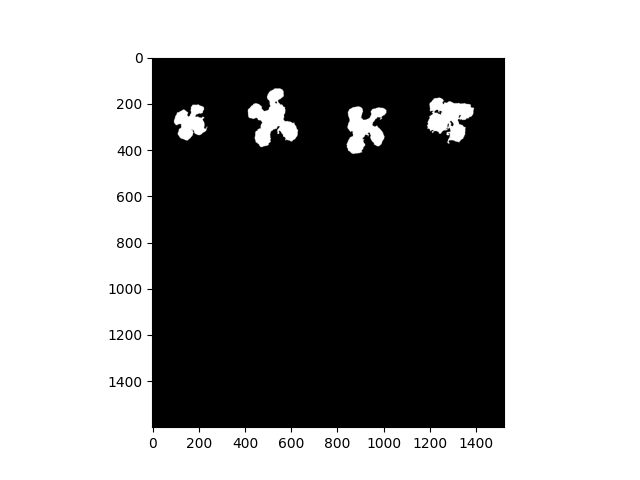

In [60]:
# Makes a new mask only with plants inside ROI

# Inputs for the filtering function:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI then still keeps whole plant if some lies outside ROI), 'cutto' (hard cut off), or 
#                     'largest' (keep only largest object)

kept_mask  = pcv.roi.filter(mask=cleaned_mask, roi=roi, roi_type='partial')

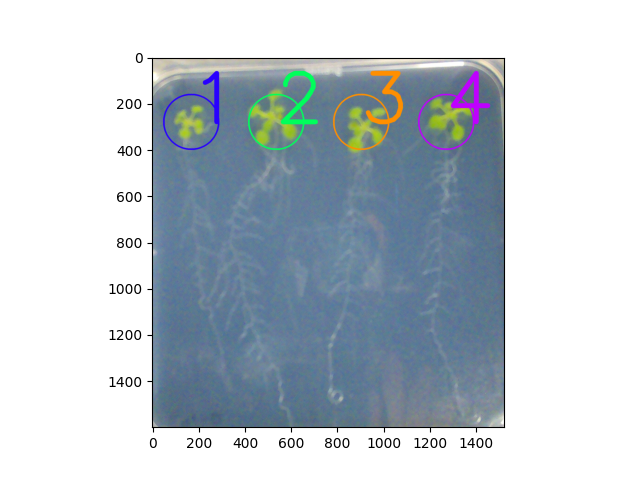

In [70]:
# Make new ROI's to select the different plants (use/change this for rows and columns of plants)
auto_rois = pcv.roi.auto_grid(mask=kept_mask, nrows=1, ncols=4, img=crop_img)

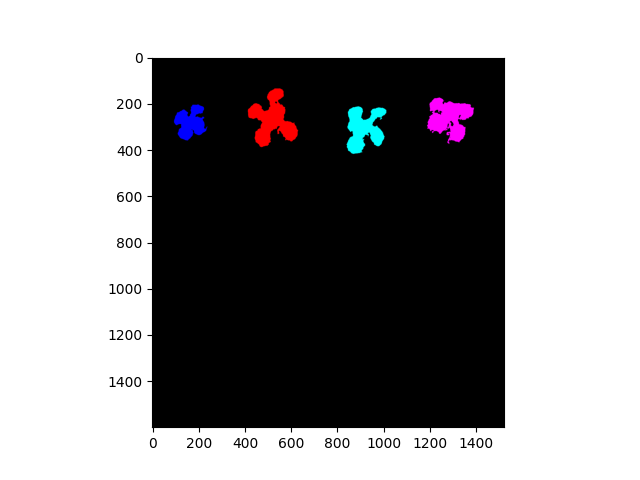

In [62]:
# Label and number objects in ROI; A good check to ensure different plants are different objects from being different colors
labeled_mask, num_plants = pcv.create_labels(mask=kept_mask, rois=auto_rois, roi_type='partial')

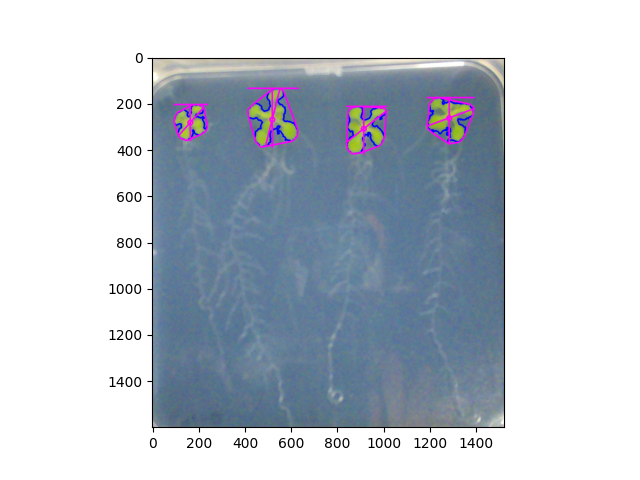

In [71]:
# Outputs analyzed image
shape_image = pcv.analyze.size(img=crop_img, labeled_mask=labeled_mask, n_labels=num_plants)

In [72]:
# Makes histogram of colors inside ROI
color_histogram = pcv.analyze.color(rgb_img=crop_img, labeled_mask=kept_mask, colorspaces='all', label="default")

alt.FacetChart(...)

In [75]:
# Saves results for the 1 image (running again overwites past results)
pcv.outputs.save_results(filename= args.result, outformat="json")

In [18]:
# Prints how many pixels were counted
for i in range(4):
    i = i+1
    pixels_value = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
    pixels_label = pcv.outputs.observations[f"default_{i}"]["area"]["label"]
    print(f"Number of pixels for plant{i}:", pixels_value, pixels_label)

Number of pixels for plant1: 2171.0 pixels
Number of pixels for plant2: 2147.0 pixels
Number of pixels for plant3: 2193.0 pixels
Number of pixels for plant4: 2422.0 pixels


In [79]:
# Gets pixels to mm scalar s (mm per pixel, so: pixels * s^2 = mm^2)
# UNCOMMENT:
# with open(scale_values_path, "r") as f:
    # scale_data = json.load(f)

mean_s = 2 #scale_data["mean_scale_mm_per_pixel"]
std_s = 2 #scale_data["std_scale_mm_per_pixel"]

In [82]:
# Create single-row DataFrame and 
for i in range(4):
    i = i+1
    pixels_value = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
    new_data = pd.DataFrame([{
        "plant_number": f"plant{i}", #need to universalize image names (with specific ID's?)
        "Area (mm^2)": pixels_value * (mean_s ** 2),
        "Uncertainty (mm^2)": pixels_value * 2 * mean_s * std_s
    }])
    # If analysis_log.csv doesn't exist, creates it with a header:
    if not os.path.isfile(analysis_results_csv_path):
        new_data.to_csv(analysis_results_csv_path, index=False)
    else:
        # Append without writing header again
        new_data.to_csv(analysis_results_csv_path, mode='a', header=False, index=False)

In [84]:
# Adds column with plant names ("plant1" next to "Col")
# Loads CSV with plant areas
df = pd.read_csv(analysis_results_csv_path)

# Loads name map (old_name -> new_name)
map_df = pd.read_csv(plant_names_path)

# Merge mapping to get the plant_name column (left_on takes left column, right_on takes right column, how keeps left dataframe intact)
df = df.merge(map_df, left_on="plant_number", right_on="old_plant_number", how="left")

# Renames column of plant names that we inputted (read as "new_name") into "plant_name" on the csv
df = df.rename(columns={"new_name": "plant_name"})

# Drops the "old_plant_number" column because it's unneeded
df = df.drop(columns=["old_plant_number"])

# Reorders csv to how we want it (use correct column titles or else Pandas will raise a KeyError)
df = df[["plant_number", "plant_name", "Area (mm^2)", "Uncertainty (mm^2)"]]

# Saves renamed file - if change to a different path, can save it to a new "renamed_output_data.csv" file
df.to_csv(analysis_results_csv_path, index=False)

In [90]:
# Moves image to longterm storage
short_term_dir = os.path.join(BASE_DIR, "Image_Holder", "Temp_Staging_Area")
long_term_dir = os.path.join(BASE_DIR, "Image_Holder", "Longterm_Storage")
filename = image_name

# Full paths
src_path = os.path.join(short_term_dir, filename)
dst_path = os.path.join(long_term_dir, filename)

# Ensure long-term folder exists
os.makedirs(long_term_dir, exist_ok=True)

# Moves file to long-term folder
shutil.move(src_path, dst_path)

'/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/Jupyter_Lab/WorkingVersion/Desktop_Version/Image_Holder/Longterm_Storage/test_image.jpg'

In [64]:
plt.close('all')